# Spam Filter

The objective of this is to create a classifier to distinguish between spam and non-spam (ham) emails.

In [917]:
from glob import glob
import pickle
import sys
print( sys.version )
from IPython.display import clear_output

import random
import collections
from functools import reduce, partial
from itertools import chain, combinations, product
from operator import methodcaller, contains
from email.parser import Parser
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.externals import joblib
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.tree import DecisionTreeClassifier

def lmap(*args, **kwargs):
    return [*map( *args, **kwargs )]

pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

3.5.2 |Continuum Analytics, Inc.| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


## Loading Data and Preprocessing

The following cell defines two functions, `simplePreprocess` and `getEmails`. 

* The `getEmails` function reads in the emails in a given folder and applies a preprocessing algorithm to convert the raw text into a list of words. 

* The `simplePreprocess` function splits an email by whitespace and filters out non-alphabetical strings.

The motivation for these functions is to allow for more advanced preprocessing techniques in the future.

In [1011]:
def getEmails( folder = None, preprocess = lambda x : x ):
    '''
        Params:
            folder: a string representing a folder
            preprocess: a function that maps strings to strings
        Returns:
            A list where each item is an email in folder
    '''
    if folder:
        files = lmap( open, glob( '%s/*.txt' % folder ) )
        emails = [ preprocess( f.read() ) for f in files ]
        map( methodcaller('close'), files )
        return emails
    else:
        return getEmails( 'spam' ) + getEmails( 'ham' )

def simplePreprocess( email ):
    ''' 
        Params: 
            email: a string representing an email
        Returns:
            A string containing the substrings of email separated by
            whitespace that are purely alphabetical composed of
            characters.
    '''
    words = [ w for w in email.split() if w.isalpha() ]
    return reduce( lambda x, y : '%s %s' % (x, y), words, '' )

def getAllWords( emails ):
    '''
        Params: emails: a list of strings
        Returns: Set of strings that appear separated 
            by whitespace in emails
    '''
    return set(sum( [ e.split() for e in emails ], [] ))

def simpleFeatureWords( emails, n = 1000 ):
    '''
        Params:
            emails: a list of strings
            n: an integer
        Returns: 
            A list containing at least n randomly selected 
            words in emails
    '''
    random.seed(0)
    allWords = getAllWords( emails )
    if n < len( allWords ):
        return random.sample( allWords, n )
    else:
        return allWords
    


def getData():
    ''' Returns a list of unprocessed emails and corresponding labels. '''
    spam = getEmails( 'spam' )
    ham = getEmails( 'ham' )
    emails = np.array( spam + ham )
    y = np.array( len( spam ) * [1] + len( ham ) * [0] )
    return emails, y
    
    
def unpackTraining( index, emails, y ):
    ''' Unpacks training data from a KFold split '''
    train_index, test_index = index
    return emails[ train_index ], y[ train_index ]

def unpackTesting( index, emails, y ):
    ''' Unpacks testing data from a KFold split '''
    train_index, test_index = index
    return emails[ test_index ], y[ test_index ]
    
def transformEmail( featureWords, email ):
    ''' 
        Returns a boolean vector describing feature 
        words that appear in an email. 
    '''
    return lmap( partial( contains, email ), featureWords )
    
def transformEmails( featureWords, preprocess, emails ):
    '''
        Params:
            featureWords: a list of strings
            preprocess: a function from strings to strings
            emails: a list of strings
        Returns:
            A matrix of boolean row vectors, where each row
            corresponds to an email and each column corresponds
            to a feature word.
    '''
    processed = lmap( preprocess, emails )
    transform = partial( transformEmail, featureWords )
    return np.matrix(lmap( transform, processed ))

def simpleModel( emails, labels,
                 getFeatureWords = simpleFeatureWords, 
                 preprocess = simplePreprocess,
                 hyperparams = { 'alpha' : 1, 'class_prior' : [0.5, 0.5] }  ):
    '''
        Constructs a simple Naive Bayes Model.
        Params:
            emails: a list of strings
            labels: a list of integers that are either 0 or 1
            getFeatureWords: a function that maps a list of 
            strings to a list of strings
            preprocess: a function that maps a string to a string
            hyperparams: a dictionary that maps an 'alpha' to a number 
            and a 'class_prior' to a list of two numbers.
        Returns:
            clf: A trained Multinomial classifier
            transform: a function that maps a list of strings to
            a data matrix.
            
    '''
    processed = lmap( preprocess, emails )
    featureWords = getFeatureWords( processed )
    transform = partial( transformEmails, featureWords, preprocess )
    clf = MultinomialNB( **hyperparams )
    X = transform( emails )
    clf.fit( X, labels )
    return clf, transform

def crossValScore( model, n_splits = 5 ):
    '''
        Params:
            model: This parameter is a function that takes a data matrix and
            a labelling vector and returns a classifier and transformation
            function. The classifier is an object that has a score method that
            takes a data matrix and a labelling vector and returns a number.
            The transformation function takes a list of totally unprocessed 
            emails and returns a data matrix.
        Returns:
            An array of scores corresponding to each CV fold.
    '''
    emails, y = getData()
    split = KFold( n_splits = n_splits, 
                   shuffle = True, 
                   random_state = 0 ).split( emails )
    scores = []
    for index in split:
        clf, transform = model( *unpackTraining( index, emails, y ) )
        emails_test, y_test = unpackTesting( index, emails, y )
        X_test = transform( emails_test )
        scores += [ clf.score( X_test, y_test ) ]
    
    return np.array(scores)



def plotHist( dist, title = '', xlabel = '', ylabel = '', color = 'b', \
              sortkey = lambda x : -x[1], ylim = [], xlim = [], rotation = 45, yerr = [],
              error_kw = None, width = 0.5, figsize = (32.0, 7.0), spacing = 1 ):
    '''
        Plots a probablity distribution as a histogram
    '''
    items = list( dist.items() )
    items.sort( key = sortkey )
    names = [ k for k, v in items ]
    counts = [ v for k, v in items ]

    # Plot histogram using matplotlib bar().
    indexes = np.arange(len(names)) * spacing
    width = width
    
    fig = plt.figure( figsize = figsize )
    ax = fig.add_subplot( 111 )
    if error_kw != None:
        ax.bar( indexes, counts, width, yerr = yerr, color = color, error_kw = error_kw )
    else:
        ax.bar( indexes, counts, width )
    ax.set_xticks( indexes + width * 0.5 )
    ax.set_xticklabels( names, rotation = rotation )
    ax.set_title( title )
    ax.set_xlabel( xlabel )
    ax.set_ylabel( ylabel )
    if xlim:
        ax.set_xlim( xlim )
    if ylim:
        ax.set_ylim( ylim )
    plt.show()

def pickingFeatures( n, 
                     getAllFeatureWords = simpleFeatureWords, 
                     preprocess = simplePreprocess ):
    print('picking %i features' % n)
    clear_output( wait = True )
    nFeatureWords = partial( getAllFeatureWords, n=n )
    return crossValScore(partial( simpleModel, getFeatureWords = nFeatureWords ))

In [610]:
xs = [ 1, 10, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 750,\
       1000, 1500, 2000, 2500, 3000, 4000, 5000, 10000, 15000 ]
mapping = { x : pickingFeatures(x) for x in xs }

picking 15000 features


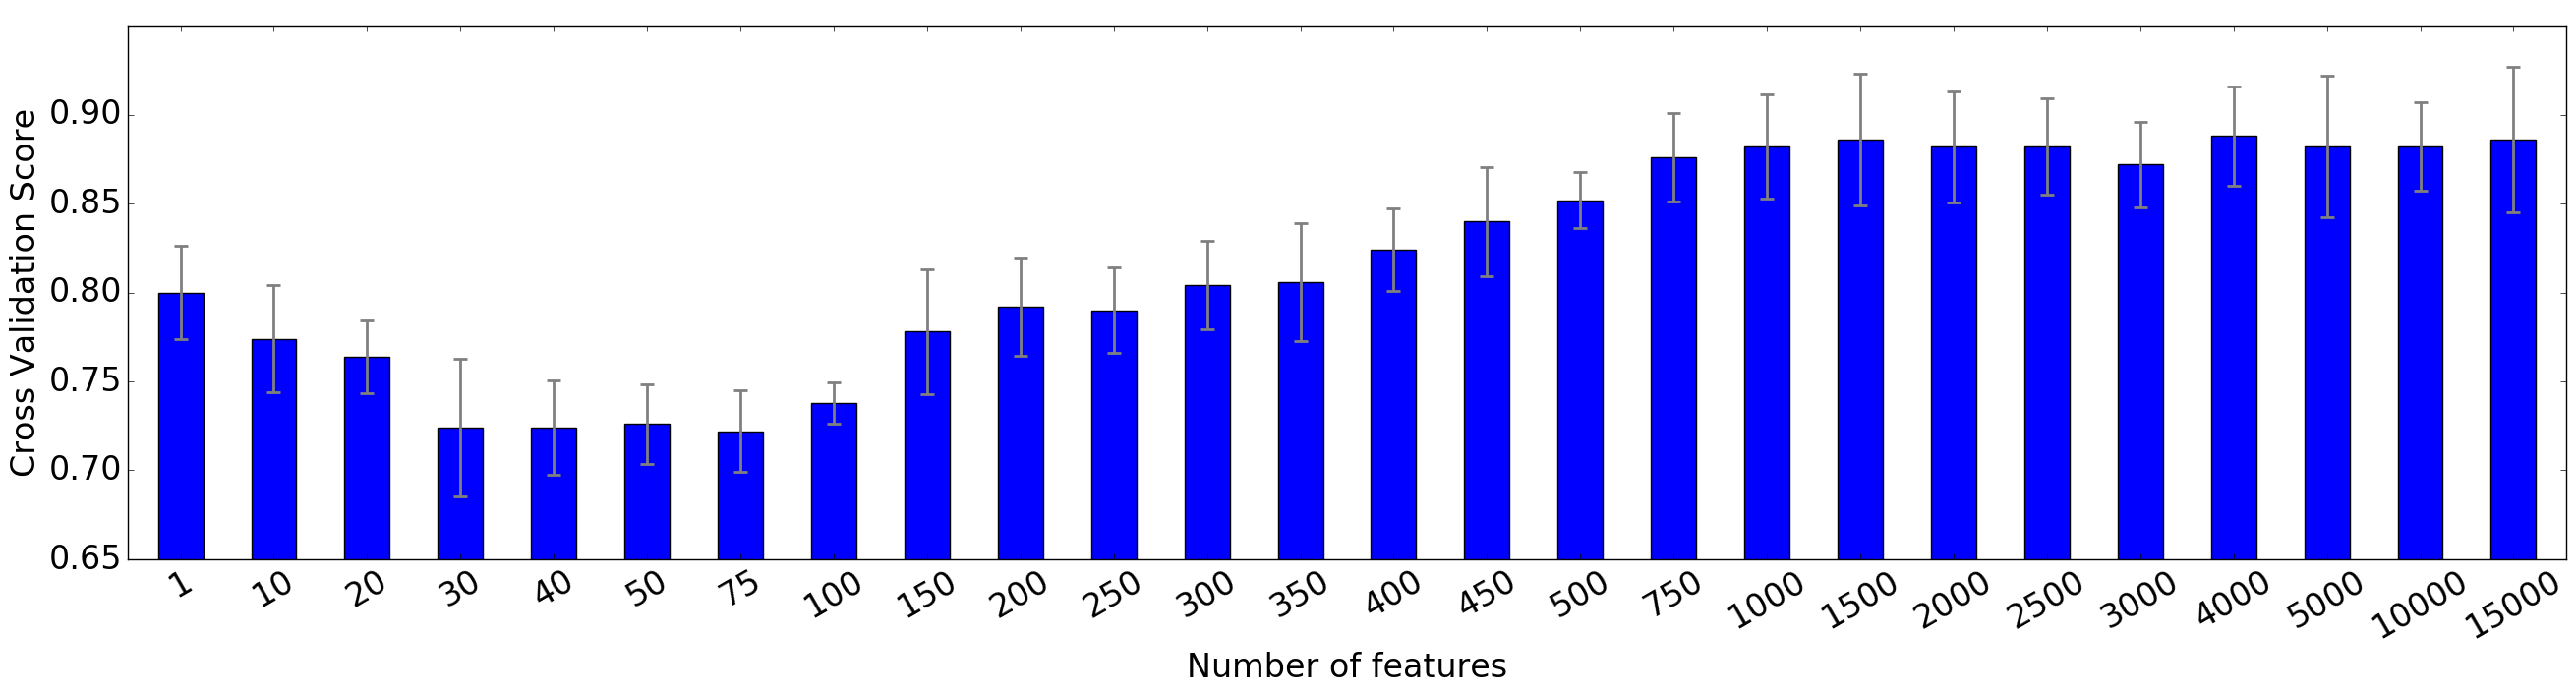

In [656]:
xy = dict( (x, scores.mean()) for x, scores in mapping.items() )
yerr = [ scores.std() for x, scores in mapping.items() ]
plotHist( xy, error_kw = dict(ecolor='gray', lw=2, capsize=5, capthick=2), \
          ylabel = 'Cross Validation Score', xlabel = 'Number of features', \
          color = 'b', sortkey = lambda x : x[0], ylim = [0.65, 0.95], xlim = [ -1, 80 ], \
          rotation = 30, yerr = yerr, width = 1.5, spacing = 3.1 )

In [876]:
def printAccuracy( scores ):
    print('Accuracy: %0.3f (+/- %0.3f)' % (scores.mean(), scores.std()))

nFeatureWords = partial( simpleFeatureWords, n=1000 )
model = partial( simpleModel, getFeatureWords = nFeatureWords )
scores = crossValScore( model )
printAccuracy( scores )

Accuracy: 0.886 (+/- 0.031)


## Creating Dummy Classifiers for Comparison

In [759]:
def dummyTransform( emails ):
    return np.matrix( [[True]] * len(emails) )

def dummyModel( emails, labels, hyperparams ):
    clf = DummyClassifier( random_state = 0, **hyperparams )
    X = dummyTransform( emails )
    clf.fit( X, labels )
    return clf, dummyTransform

for strategy in [ 'uniform', 'most_frequent' ]:
    model = partial( dummyModel, hyperparams = { 'strategy' : strategy } )
    printAccuracy( crossValScore( model, n_splits=10 ) )

Accuracy: 0.492 (+/- 0.06)
Accuracy: 0.800 (+/- 0.11)


## Analysing Simple Email Features

## Labelling and Feature Extraction

The `getData` function takes a feature extraction function `featureExtract` as a parameter and a `preprocess` function as a parameter and returns a data matrix and a list of labels. Each row in the data matrix corresponds to an email and each column corresponds to a feature.

The next step is to determine how many of the top most differentiating words to use for feature extraction. The `pickingFeatures` function takes an integer `n` and takes the top `n` most differentiating words and creates a data matrix by checking for the presence of those words in the emails. This is then used to train a `BernoulliNB` classifier and the function then returns the mean 5-fold cross validation score.

## More Advanced Preprocessing


So far the preprocessing has been very minimal, the next step will be to separate the content of the emails from the formatting of the emails.

In [909]:
def constructModel( emails, labels,
                    preprocess = lambda x : x,
                    hyperparams = {},
                    vecparams = {},
                    ret_vectorizer = False ):
    '''
        Constructs a Naive Bayes Model.
        Params:
            emails: a list of strings
            labels: a list of integers that are either 0 or 1
            getFeatureWords: a function that maps a list of 
            strings to a list of strings
            preprocess: a function that maps a string to a string
            hyperparams: a dictionary that maps an 'alpha' to a number 
            and a 'class_prior' to a list of two numbers.
        Returns:
            clf: A trained Multinomial classifier
            transform (if not ret_vectorizer): a function that maps a 
            list of strings to a data matrix.
            vectorizer (if ret_vectorizer): A fitted CountVectorizer
    '''
    vecdefaults = { 'binary'        : True, 
                    'preprocessor'  : preprocess, 
                    'token_pattern' : r'\s+(\b\w+\b*)\s+', 
                    'strip_accents' : True, 
                    'lowercase'     : True }
    vecparams = dict( (k, vecparams[k] if k in vecparams else vecdefaults[k]) 
                      for k in vecdefaults )
    vectorizer = CountVectorizer( **vecparams )
    vectorizer.fit( emails )
    X = vectorizer.transform( emails )
    
    hyperdefaults = { 'alpha' : 1, 'class_prior' : [0.5, 0.5] }
    hyperparams = dict( (k, hyperparams[k] if k in hyperparams else hyperdefaults[k]) 
                      for k in hyperdefaults )
    clf = MultinomialNB( **hyperparams )
    clf.fit( X, labels )
    if ret_vectorizer:
        return clf, vectorizer
    return clf, vectorizer.transform

In [803]:
printAccuracy(crossValScore( simpleModel ))

Accuracy: 0.886 (+/- 0.03)


In [842]:
printAccuracy(crossValScore( constructModel ))

Accuracy: 0.880 (+/- 0.03)


In [843]:
vecparams = { 'token_pattern' : r'\b\w+\b' } # tokenize by words
model = partial( constructModel, vecparams = vecparams )
printAccuracy(crossValScore( model ))

Accuracy: 0.910 (+/- 0.02)


In [846]:
vecparams = { 'token_pattern' : r'\b\w\w+\b' } # tokenize by words
model = partial( constructModel, vecparams = vecparams )
printAccuracy(crossValScore( model ))

Accuracy: 0.912 (+/- 0.01)


In [662]:
def countVectorizing( preprocessor = lambda x : x ):
    spamEmails = getEmails( 'spam' ) 
    hamEmails = getEmails( 'ham' )
    emails = spamEmails + hamEmails
    vectorizer = CountVectorizer( binary = True, preprocessor = preprocessor )
    vectorizer.fit( spamEmails )
    X = vectorizer.transform( emails )
    y = len( spamEmails ) * [0] + len( hamEmails ) * [1]
    clf = MultinomialNB()
    scores = cross_val_score( clf, X, y, cv=5 )
    print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return vectorizer

vectorizer = countVectorizing()

Accuracy: 0.922 (+/- 0.05)


In [1070]:
def multipartContent( email ):
    payload = email.get_payload()
    content = [ multipartContent(x) if x.is_multipart() else x.get_payload() for x in payload ]
    return reduce( lambda x, y : x + ' ' + y, content, '' )

def contentOnly( e ):
    parser = Parser()
    email = parser.parsestr(e)
    content = email.get_payload()
    if email.is_multipart():
        return multipartContent( email )
    return content

def contentAndRelevantHeaders( text ):
    content = contentOnly( text )
    parser = Parser()
    email = parser.parsestr( text )
    headers = []
    for k, v in email.items():
        if k in [ 'Subject', 'To', 'From'  ]:
            headers.append( v )
    return reduce( lambda x, y : '%s %s' % (y, x), headers + [content], '' )

def processSymbols( text ):
    text = re.sub( r'__+', ' multiscore ', text )
    text = re.sub( r'\*(\*)+', ' multistar ', text )
    text = re.sub( r'\!(\!)+', ' multibang ', text )
    text = re.sub( r'\?(\?)+', ' multiques ', text )
    text = re.sub( r'\.(\.)+', ' multidots ', text )
    text = re.sub( r'#(#)+', ' multihash ', text )
    text = re.sub( r'-(-)+', ' multidash ', text )
    text = text.replace( '$', ' money ' )
    text = text.replace( '£', ' money ' )
    text = text.replace( '!', ' bang ' )
    text = text.replace( '%', ' percent ' )
    text = text.replace( '&', ' and ' )
    for symbol in [ '.', ',', '@', '_', '<', '>', '{', '}' '\\', '/', '#', '^', '=', \
                    '(', ')', '"', ':', ';', '~', '+', '*', '?', '[', ']', '\%' ]:
        text = text.replace( symbol, ' ' )
    return text

def hasNumbers( string ):
    return any( c.isdigit() for c in string )

def isNumber( string ):
    return string.replace('.', '').isdigit()

def isAscii(s):
    return all(ord(c) < 128 for c in s)

def processNumerics( text ):
    words = text.split()
    words = [ 'num'      if isNumber(w)    else w for w in words ]
    words = [ 'alphanum' if hasNumbers(w)  else w for w in words ]
    words = [ 'nonascii' if not isAscii(w) else w for w in words ]
    return reduce( lambda x, y : '%s %s' % (x, y), words, '' )

def processHyperlinks( text ):
    text = re.sub(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' #domain...
        r'localhost|' # localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
        r'(?::\d+)?' # optional port
        r'(?:/?|[/?]\S+)$', ' hyperlink ', text )
    text = re.sub( r'^https?:\/\/.*[\r\n]*', ' hyperlink ', text )
    text = re.sub( r'<.*?>', ' htmltag ', text )
    return text

def isAllCaps( string ):
    return all(map( methodcaller('isupper'), string ))

def processCapitals( text ):
    words = text.split()
    words = [ ' allcaps %s ' % w if isAllCaps(w) else w for w in words ]
    words = map( methodcaller('lower'), words )
    return reduce( lambda x, y : '%s %s' % (x, y), words, '' )

def advancedPreprocess( email ):
    text = contentAndRelevantHeaders( email )
    text = processHyperlinks( text )
    text = processNumerics( text )
    text = processSymbols( text )
    text = processCapitals( text )
    words = [ w for w in text.split() if 20 > len(w) > 1 ]
    return reduce( lambda x, y : '%s %s' % (x, y), words, '' ) 

In [856]:
vecparams = { 'token_pattern' : r'\b\w\w+\b' }
model = partial( constructModel, 
                 preprocess = contentOnly,
                 vecparams = vecparams )
printAccuracy(crossValScore( model ))

Accuracy: 0.916 (+/- 0.02)


In [854]:
model = partial( constructModel, 
                 preprocess = contentAndRelevantHeaders,
                 vecparams = vecparams )
printAccuracy(crossValScore( model ))

Accuracy: 0.930 (+/- 0.02)


In [857]:
model = partial( constructModel, 
                 preprocess = processSymbols,
                 vecparams = vecparams )
printAccuracy(crossValScore( model ))

Accuracy: 0.916 (+/- 0.01)


In [859]:
model = partial( constructModel, 
                 preprocess = processNumerics,
                 vecparams = vecparams )
printAccuracy(crossValScore( model ))

Accuracy: 0.932 (+/- 0.02)


In [858]:
model = partial( constructModel, 
                 preprocess = processCapitals,
                 vecparams = vecparams )
printAccuracy(crossValScore( model ))

Accuracy: 0.914 (+/- 0.03)


In [883]:
model = partial( constructModel, 
                 preprocess = advancedPreprocess,
                 vecparams = vecparams )
printAccuracy(crossValScore( model ))

Accuracy: 0.938 (+/- 0.027)


In [1072]:
emails, labels = getData()

vecparams = { 'binary'        : True, 
                'preprocessor'  : advancedPreprocess, 
                'token_pattern' : r'\b\w\w+\b', 
                'strip_accents' : True, 
                'lowercase'     : True }
vectorizer = CountVectorizer( **vecparams )
vectorizer.fit( emails )
X = vectorizer.transform( emails )

hyperparams = { 'alpha' : 0.7, 'class_prior' : [0.9, 0.1] }
clf = MultinomialNB( **hyperparams )
clf.fit( X, labels )

# printAccuracy(crossValScore( lambda es, ls : clf, vectorizer.transform ))
joblib.dump( clf, 'classifier.dat' )
with open( 'vocab.txt', 'w' ) as f:
    for w in vectorizer.get_feature_names():
        f.write( '%s\n' % w )

In [1065]:
help( joblib.dump )

Help on function dump in module sklearn.externals.joblib.numpy_pickle:

dump(value, filename, compress=0, protocol=None, cache_size=None)
    Persist an arbitrary Python object into one file.
    
    Parameters
    -----------
    value: any Python object
        The object to store to disk.
    filename: str or pathlib.Path
        The path of the file in which it is to be stored. The compression
        method corresponding to one of the supported filename extensions ('.z',
        '.gz', '.bz2', '.xz' or '.lzma') will be used automatically.
    compress: int from 0 to 9 or bool or 2-tuple, optional
        Optional compression level for the data. 0 or False is no compression.
        Higher value means more compression, but also slower read and
        write times. Using a value of 3 is often a good compromise.
        See the notes for more details.
        If compress is True, the compression level used is 3.
        If compress is a 2-tuple, the first element must correspond to 

In [1058]:
def probabilities( emails, words ):
    '''
        Given a list were each item is a list of words,
        returns a dictionary that map words to probabilties
    '''
    ws = sum( [ [ w for w in e.split() if w in words ] for e in emails ], [] )
    counter = collections.Counter( ws )
    return { k : v / len( ws ) for k, v in counter.items() }

# def getMostProbable( dist, t ):
#     '''
#         Given a probability distribution and a number of instances to get,
#         returns the n most probable instances
#     '''
#     maxV = max( dist.values() )
#     return { k : v for k, v in dist.items() if v >= t * maxV }
    
def histDifference( h1, h2 ):
    '''
        Given two probability distributions,
        returns a new distribution representing a key-wise difference
    '''
    return { k : h1[ k ] - h2[ k ] for k in h1.keys() if k in h2 }

# def getMostIdentifying( spam, ham, words ):
#     spamProbs = probabilities( spam, words )
#     hamProbs  = probabilities( ham, words )
#     spamHamDiff = histDifference( spamProbs, hamProbs )
#     hamSpamDiff = histDifference( hamProbs, spamProbs )
#     return dict( ( k, abs( spamHamDiff[k] - hamSpamDiff[k] ) ) 
#                   for k in chain( hamSpamDiff, spamHamDiff ) )

def getFeatureWords( emails, labels ):
    spam = [ e for e, l in zip( emails, labels ) if l == 1 ]
    ham  = [ e for e, l in zip( emails, labels ) if l == 0 ]
    words = getAllWords( emails )
    spamProbs = probabilities( spam, words )
    hamProbs  = probabilities( ham, words )
    spamHamDiff = histDifference( spamProbs, hamProbs )
    hamSpamDiff = histDifference( hamProbs, spamProbs )
    mostIdentifying = dict( ( k, max( abs(spamHamDiff[k]), abs(hamSpamDiff[k]) ) ) 
                             for k in chain( hamSpamDiff, spamHamDiff ) )
    
    return mostIdentifying


In [1063]:
class WeightedMultinomialNB( MultinomialNB ):
    
    def __init__( self, weights, **kwargs ):
        super( WeightedMultinomialNB, self ).__init__( **kwargs )
        self.weights = np.array(weights)
    
    def _update_feature_log_prob( self ):
        ''' Weight the feature logarithm probabilities '''
        super( WeightedMultinomialNB, self )._update_feature_log_prob()
        self.feature_log_prob_ += np.log(1 + 10 * self.weights)
        

In [1056]:
def advancedModel( emails, labels,
                      vecparams = {},
                      hyperparams = {} ):
    
    processed = lmap( advancedPreprocess, emails )
    featureWords = getFeatureWords( emails, labels )
    
    vecdefaults = { 'binary'        : True, 
                    'preprocessor'  : advancedPreprocess, 
                    'token_pattern' : r'\b\w\w+\b', 
                    'strip_accents' : True, 
                    'lowercase'     : True }
    vecparams = dict( (k, vecparams[k] if k in vecparams else vecdefaults[k]) 
                      for k in vecdefaults )
    
    vectorizer = CountVectorizer( vocabulary = list(featureWords.keys()), 
                                 **vecparams )
    vectorizer.fit( emails )
    X = vectorizer.transform( emails )
    print(X.shape)
    hyperdefaults = { 'alpha' : 0.7, 'class_prior' : [0.8, 0.2] }
    hyperparams = dict( (k, hyperparams[k] if k in hyperparams else hyperdefaults[k]) 
                      for k in hyperdefaults )
    clf = WeightedMultinomialNB( list(featureWords.values()), **hyperparams )
    clf.fit( X, labels )
    
    return clf, vectorizer.transform

In [1064]:
printAccuracy(crossValScore( advancedModel ) )

(400, 4170)
(400, 3957)
(400, 4009)
(400, 3896)
(400, 4059)
Accuracy: 0.956 (+/- 0.021)


In [984]:
def alternativeModel( emails, labels,
                      vecparams = {},
                      hyperparams = {} ):
    
    processed = lmap( advancedPreprocess, emails )
    featureWords = getFeatureWords( emails, labels, )
    
    vecdefaults = { 'binary'        : True, 
                    'preprocessor'  : advancedPreprocess, 
                    'token_pattern' : r'\b\w\w+\b', 
                    'strip_accents' : True, 
                    'lowercase'     : True }
    vecparams = dict( (k, vecparams[k] if k in vecparams else vecdefaults[k]) 
                      for k in vecdefaults )
    
    vectorizer = CountVectorizer( vocabulary = featureWords, **vecparams )
    vectorizer.fit( emails )
    X = vectorizer.transform( emails )
    print(X.shape)
    clf = DecisionTreeClassifier( **hyperparams )
    clf.fit( X, labels )
    
    return clf, vectorizer.transform

In [985]:
hyperparams = {
    'class_weight' : { 1 : 0.1, 0 : 0.9 },
    'criterion'    : 'entropy',
    'max_features' : 0.7,
    'max_depth'    : None
}
model = partial( alternativeModel, hyperparams = hyperparams )
printAccuracy(crossValScore( model ))

(400, 1000)
(400, 1000)
(400, 1000)
(400, 1000)
(400, 1000)
Accuracy: 0.840 (+/- 0.033)


In [956]:
def computeHyperparamSurface( modelConstructor, hyperparamSpace ):
    '''
        Params:
            modelConstructor: function that returns a classifier and 
            transform function
            hyperparamSpace: dictionary mapping kwargs to parameter spaces
        Returns:
            Meshgrid xx, yy that map to surface zz
        Example:
            hyperparamSpace = {
                'max_depth' : [100, 500, 1000],
                'max_features' : [100, 500, 1000]
            }
            xx, yy, zz = computeHyperparamSurface( alternativeModel, hyperparamSpace )
    '''
    xx, yy = pylab.meshgrid( *hyperparamSpace.values() )
    keys = hyperparamSpace.keys()
    zz = np.zeros( xx.shape )
    for i, j in product(*map(range, xx.shape )):
        hyperparams = dict(zip( keys, [ xx[ i, j ], yy[ i, j ] ]))
        model = partial( modelConstructor, hyperparams = hyperparams )
        zz[ i, j ] = crossValScore( model ).mean()
        
    return xx, yy, zz

def visualiseHyperparamSurface( xx, yy, zz ):
    fig, ax = plt.subplots()
    ax.set_ylabel( 'Parameter 1' )
    ax.set_xlabel( 'Parameter 2' )
    ax.set_xlim([ np.min(xx), 2*np.max(xx) ])
    ax.set_ylim([ np.min(yy), 2*np.max(yy) ])
    cax = ax.pcolor( xx, yy, zz, cmap='viridis' )
    fig.colorbar( cax  )
    plt.show()

In [ ]:
hyperparamSpace = {
    'max_depth' : [1000, 2000],
    'max_features' : [1000, 2000]
}
xx, yy, zz = computeHyperparamSurface( alternativeModel, hyperparamSpace )

In [65]:
xy = dict( (x, scores.mean()) for x, scores in mapping.items() )
yerr = [ scores.std() for x, scores in mapping.items() ]
plotHist( xy, error_kw = dict(ecolor='gray', lw=2, capsize=5, capthick=2), \
          ylabel = 'Cross Validation Score', xlabel = 'Number of features', \
          color = 'b', sortkey = lambda x : x[0], ylim = [0.65, 0.95], xlim = [ -1, 80 ], \
          rotation = 30, yerr = yerr, width = 1.5, spacing = 3.1 )

## Dimensionality Reduction

In [488]:
def idealGridSize( n ):
    bound = 1 + int(np.ceil(np.sqrt( n )))
    size = (1, n)
    for i in range( 1, bound ):
        if not n % i:
            j = n // i
            size = (i, j)
    return size

def showScatters( scatters, labels, orientation = 'horizontal' ):
    l = len( scatters )
    if orientation == 'vertical':
        ncols, nrows = idealGridSize( l )
    else:
        nrows, ncols = idealGridSize( l )
        
    fig = plt.figure()
    for plotnum in range( ncols * nrows ):
        ax = fig.add_subplot( nrows, ncols, plotnum + 1 )
        ax.axis( 'off' )
        xs, ys, features = scatters[ plotnum ]
        ax.set_title( "f%i f%i" % features )
        ax.scatter( xs, ys, 5, color=labels )
    fig.tight_layout()
    plt.show()

def getFeatureScatters( X, n ):
    
    scatters = []
    
    for f1, f2 in combinations( range(1, n), 2 ):
        scatters.append(( X[ :, f1 ], X[ :, f2 ], (f1, f2) ))
        clear_output( wait = True )
        
    return scatters

In [490]:
spamEmails = getEmails( 'spam' ) 
hamEmails = getEmails( 'ham' )
emails = spamEmails + hamEmails

vectorizer = CountVectorizer( min_df = 1,
                              preprocessor = advancedPreprocess )
dtm = vectorizer.fit_transform( spamEmails )

# svd = TruncatedSVD( 50, algorithm = 'arpack' )
# dtm_svd = svd.fit_transform( dtm )

# pca = PCA( n_components = 10, svd_solver = 'full' )
# pca.fit( dtm_svd )

# T = [ vectorizer, svd, pca ]
# X = reduce( lambda x, y : y.transform(x), T, emails )
# # X = pca.transform(svd.transform(vectorizer.transform(emails)))

# labels = ['r'] * len(spamEmails) + ['b'] * len(hamEmails)
# showScatters( getFeatureScatters( X, pca.n_components_ ), labels )

In [795]:
spamEmails = getEmails( 'spam' ) 
hamEmails = getEmails( 'ham' )
emails = spamEmails + hamEmails
vectorizer = CountVectorizer( binary = True, preprocessor = advancedPreprocess )
vectorizer.fit( spamEmails )
X = vectorizer.transform( emails )
y = len( spamEmails ) * [0] + len( hamEmails ) * [1]
clf = MultinomialNB()
scores = cross_val_score( clf, X, y, cv=5 )
print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.934 (+/- 0.05)


In [850]:
with open( 'vocab.txt' ) as f:
    vocab = sum( [ l.split() for l in f.readlines() ], [] )

vectorizer = CountVectorizer( binary = True, vocabulary = vocab, preprocessor = advancedPreprocess )
spamEmails = getEmails( 'spam' ) 
hamEmails = getEmails( 'ham' )
emails = spamEmails + hamEmails
X = vectorizer.transform( emails )
y = len( spamEmails ) * [0] + len( hamEmails ) * [1] 
clf = MultinomialNB( alpha = 0.7, class_prior = [ 0.81, 0.19 ] )
scores = cross_val_score( clf, X, y, cv=5 )
print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.958 (+/- 0.03)


In [154]:
with open( 'vocab.txt' ) as f:
    vocab = sum( [ l.split() for l in f.readlines() ], [] )

vectorizer = CountVectorizer( binary = True, vocabulary = vocab, preprocessor = advancedPreprocess )
spamEmails = getEmails( 'spam' ) 
hamEmails = getEmails( 'ham' )
emails = spamEmails + hamEmails
X = vectorizer.transform( emails )
y = len( spamEmails ) * [0] + len( hamEmails ) * [1] 

def score( params ):
    return cross_val_score( MultinomialNB( **params ), X, y, cv=5 ).mean()
    
def scoreParams( paramSpace ):
    keys = map( tuple, map( methodcaller('values'), paramSpace ) )
    return dict(zip( keys, map( score, paramSpace ) ))
# params = [{
#     'alpha' : alpha, 'fit_prior' : fit_prior, 'class_prior' : ( class_prior, 1 - class_prior )
#     } for alpha in alphas
#       for fit_prior in [ True, False ] 
#       for class_prior in class_priors
# ]
# mapping = scoreParams( params )
# items = list(mapping.items())
# items.sort( key = lambda x : -x[1] )

In [193]:
step = 0.01
alphas = np.arange( 0.1, 2, step ) 
class_priors = np.arange( 0.1, 0.9, step )

xx, yy = pylab.meshgrid( alphas, class_priors )
zz = np.zeros( xx.shape )
for i, j in product(*map(range, xx.shape )):
    params = {
        'alpha' : xx[ i, j ], 'fit_prior' : True, 
        'class_prior' : ( yy[ i, j ], 1 - yy[ i, j ] )
    }
    zz[ i, j ] = score( params )

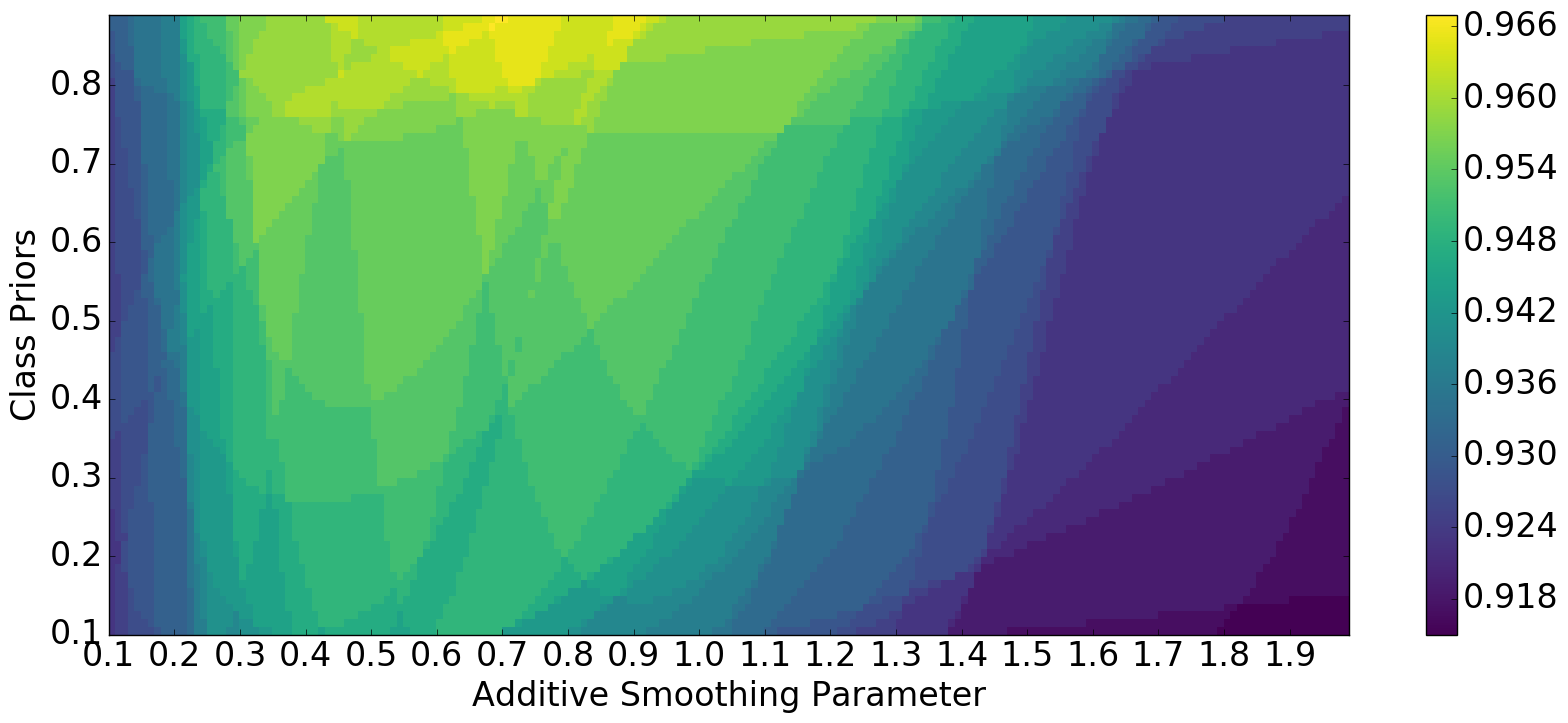

In [902]:
fig, ax = plt.subplots( figsize = (20, 8) )
ax.set_xlim([ 0.1, 1.99 ])
ax.set_ylim([ 0.1, 0.89 ])
ax.set_xticks( np.arange( 0.1, 2, 0.1 ) )
ax.set_yticks( np.arange( 0.1, 0.9, 0.1 ) )
ax.set_ylabel( 'Class Prior' )
ax.set_xlabel( 'Additive Smoothing Parameter' )
cax = ax.pcolor( xx, yy, zz + 0.007, cmap='viridis' )
fig.colorbar( cax  )
plt.show()

In [893]:
hyperparams = { 'alpha' : 0.7, 'class_prior' : [0.9, 0.1] }
model = partial( constructModel, 
                 preprocess = advancedPreprocess,
                 vecparams = vecparams,
                 hyperparams = hyperparams )
printAccuracy(crossValScore( model ))

Accuracy: 0.968 (+/- 0.015)


In [339]:
with open( 'vocab.txt' ) as f:
    vocab = sum( [ l.split() for l in f.readlines() ], [] )

vectorizer = CountVectorizer( binary = True, vocabulary = vocab, preprocessor = advancedPreprocess )
spamEmails = getEmails( 'spam' ) 
hamEmails = getEmails( 'ham' )
emails = spamEmails + hamEmails
X = vectorizer.transform( emails )
y = len( spamEmails ) * [0] + len( hamEmails ) * [1] 

params = {
    'alpha' : 0.7, 'fit_prior' : True, 
    'class_prior' : ( 0.85, 0.15 )
}
scores = cross_val_score( MultinomialNB( **params ), X, y, cv=5 )
print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.958 (+/- 0.03)
